# Plot basin-wide trends in the data

## Get the geological units of interest

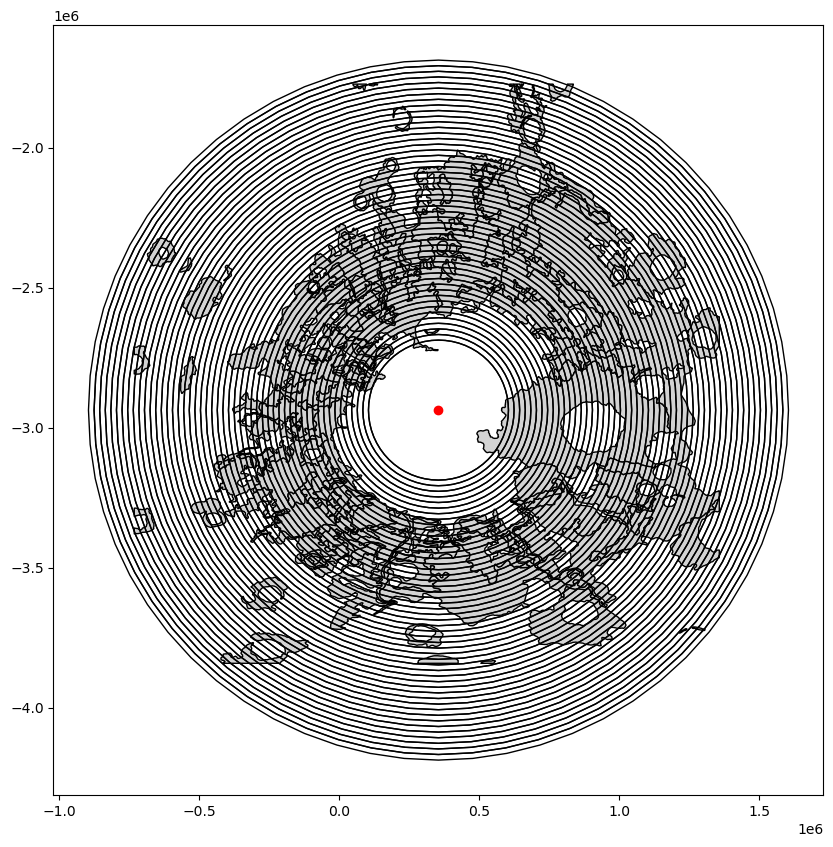

,ring_id,distance,area_within_ring,normalized_area
0,1,250000,7.652198e+09,0.004744
1,2,270000,5.889318e+09,0.003651
2,3,290000,8.382409e+09,0.005196
3,4,310000,9.506026e+09,0.005893
4,5,330000,1.098004e+10,0.006806


In [1]:
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import os
import pandas as pd

os.environ["PROJ_IGNORE_CELESTIAL_BODY"] = "YES"

# File paths
geological_units_path = "/Users/phillipsm/Documents/Research/MassifMapping/ArgyreMap/Argyre_3M_preliminary/Argyre_working/Argyre_3M_v10.gdb"
layer_name = "UnitPolygons24"
center_point_path = '/Users/phillipsm/Documents/Research/MassifMapping/Argyre_QGIS/arygre_center_point.shp'

# Load the geological units and center point(s)
geological_units = gpd.read_file(geological_units_path, layer=layer_name)
center_points = gpd.read_file(center_point_path)

# Ensure both are in the same CRS (projected CRS is preferred for area calculations)
geological_units = geological_units.to_crs(center_points.crs)

# Define the geological units of interest
target_units = [
    'Argyre basin member 2', 'Argyre basin member 3', 'Argyre rim materials',
    'Argyre rim and basin materials', 'Argye rim and basin materials',
    'Argyre basin and rim materials', 'Young crater materials', 'Old crater materials'
]

# Filter geological units to include only the specified units
filtered_geological_units = geological_units[geological_units['UnitName'].isin(target_units)]

# Define buffer distances for rings in meters
min_d, max_d = (250000, 1250000)
bs = 20000  # bin spacing in meters
buffer_distances = [min_d + i * bs for i in range(1+int((max_d - min_d) / bs))]

# Initialize an empty list to store results
summary_list = []
# Initialize an empty GeoDataFrame for the ring buffers
ring_buffers = gpd.GeoDataFrame(columns=['geometry', 'ring_id', 'distance'], crs=center_points.crs)

# Calculate area of geological units within each ring buffer
for i, dist in enumerate(buffer_distances):
    outer_buffer = center_points.geometry.buffer(dist)
    
    # Check for an inner buffer (to create a true ring)
    if i == 0:
        ring = outer_buffer
    else:
        inner_buffer = center_points.geometry.buffer(buffer_distances[i - 1])
        ring = outer_buffer.difference(inner_buffer.unary_union)  # Create ring by subtracting inner buffer
    
    # Convert the ring to a GeoDataFrame
    ring_gdf = gpd.GeoDataFrame(geometry=ring, crs=center_points.crs)
    ring_gdf['distance'] = dist  # Add distance label for reference
       
    # Append to the main GeoDataFrame
    ring_buffers = pd.concat([ring_buffers, ring_gdf], ignore_index=True)
    
    # Intersect geological units with the ring to get the area of each unit within this ring
    intersecting_units = filtered_geological_units[filtered_geological_units.intersects(ring_gdf.unary_union)]
    intersecting_units = intersecting_units.copy()
    intersecting_units['area_within_ring'] = intersecting_units.intersection(ring_gdf.unary_union).area
    
    # Summarize the area by geological unit within the ring
    area_summary = (
        intersecting_units.groupby('UnitName')['area_within_ring']
        .sum()
        .reindex(target_units, fill_value=0)
        .reset_index()
    )
    
    # Add distance and ring ID to the summary
    area_summary['ring_id'] = i + 1
    area_summary['distance'] = dist
    
    # Append to the summary list
    summary_list.append(area_summary)

# Concatenate all summaries into a single DataFrame
summary_df = pd.concat(summary_list, ignore_index=True)

# Calculate total area per ring for normalization
area_sum_by_ring = summary_df.groupby(['ring_id', 'distance'])['area_within_ring'].sum().reset_index()
total_area = area_sum_by_ring['area_within_ring'].sum()
area_sum_by_ring['normalized_area'] = area_sum_by_ring['area_within_ring'] / total_area

# Optional: Visualize the rings and geological units
fig, ax = plt.subplots(figsize=(10, 10))
filtered_geological_units.plot(ax=ax,color='lightgrey', edgecolor='black')
# ring_gdf.plot(ax=ax, color='none', edgecolor='red')
# Plot the rings (buffered zones) around the central points
ring_buffers.plot(ax=ax, color='none', edgecolor='black', label='Rings')

center_points.plot(ax=ax, color='red')
plt.show()

area_sum_by_ring.head()


## Make scatter plot of distance vs elevation and histograms 

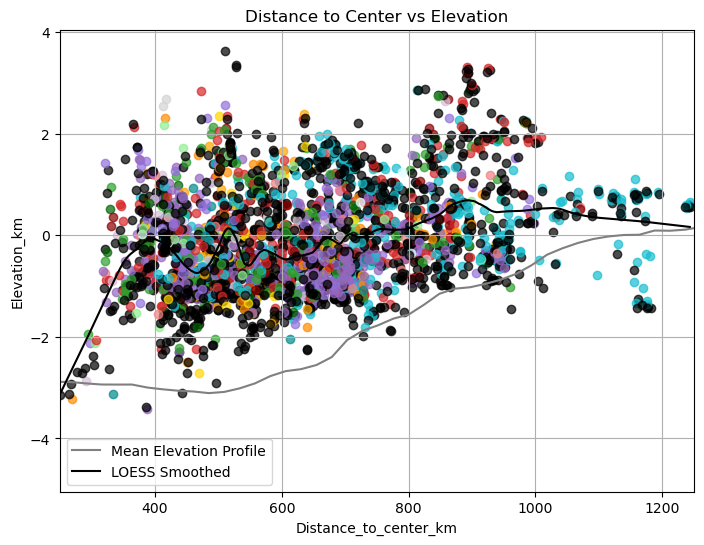

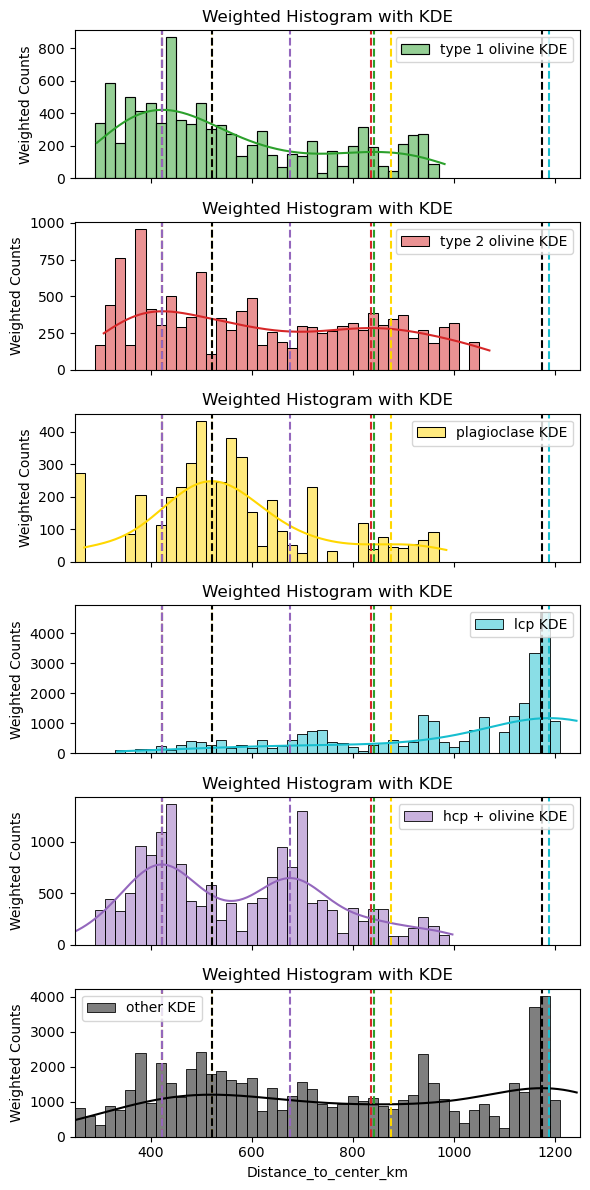

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.nonparametric.kernel_density import KDEMultivariate
from scipy.stats import gaussian_kde
from scipy.signal import find_peaks
import numpy as np
from statsmodels.nonparametric.smoothers_lowess import lowess

# Load the categorized Excel file
DATE_STRING = '12172024'
file_path = f'/Users/phillipsm/Documents/Research/MassifMapping/Argyre_QGIS/mineral_unit_metadata_categorized_{DATE_STRING}.xlsx'
df = pd.read_excel(file_path)

category_colors = {
    'type 1 olivine': {'High': 'tab:green', 'Moderate': 'darkgreen', 'Low': 'lightgreen'},
    'type 2 olivine': {'High': 'tab:red', 'Moderate': 'darkred', 'Low': 'lightcoral'},
    'olivine': {'High': 'tab:red', 'Moderate': 'darkred', 'Low': 'lightcoral'},
    'hcp + olivine': {'High': 'tab:purple', 'Moderate': 'mediumpurple', 'Low': 'thistle'},
    'lcp': {'High': 'tab:cyan', 'Moderate': 'darkcyan', 'Low': 'lightcyan'},
    'plagioclase': {'High': 'gold', 'Moderate': 'orange', 'Low': 'darkorange'},
    'alteration + olivine': {'High': 'tab:purple', 'Moderate': 'darkslateblue', 'Low': 'thistle'},
    'olivine + plagioclase': {'High': 'tab:green', 'Moderate': 'darkgreen', 'Low': 'lightgreen'},
    'alteration + olivine + plagioclase': {'High': 'tab:cyan', 'Moderate': 'darkcyan', 'Low': 'lightcyan'},
    'alteration + plagioclase': {'High': 'tab:brown', 'Moderate': 'saddlebrown', 'Low': 'peru'},
    'hcp + lcp': {'High': 'tab:pink', 'Moderate': 'hotpink', 'Low': 'lightpink'},
    'alteration + hcp + olivine': {'High': 'tab:orange', 'Moderate': 'darkorange', 'Low': 'lightsalmon'},
    'hcp + olivine + plagioclase': {'High': 'lime', 'Moderate': 'green', 'Low': 'lightgreen'},
    'red slope': {'High': 'tab:gray', 'Moderate': 'darkgray', 'Low': 'lightgray'},
    'alteration': {'High': 'tab:blue', 'Moderate': 'mediumblue', 'Low': 'lightblue'},
    'lcp + olivine': {'High': 'tab:brown', 'Moderate': 'saddlebrown', 'Low': 'peru'},
    'hcp + plagioclase': {'High': 'tab:olive', 'Moderate': 'darkkhaki', 'Low': 'palegoldenrod'},
    'hcp + lcp + olivine': {'High': 'teal', 'Moderate': 'darkslategray', 'Low': 'lightseagreen'},
    'lcp + plagioclase': {'High': 'tab:olive', 'Moderate': 'darkkhaki', 'Low': 'palegoldenrod'},
    'lcp + olivine + plagioclase': {'High': 'gold', 'Moderate': 'darkgoldenrod', 'Low': 'khaki'},
    'hcp': {'High': 'tab:pink', 'Moderate': 'hotpink', 'Low': 'lightpink'},
    'olivine + olivine': {'High': 'tab:green', 'Moderate': 'darkgreen', 'Low': 'lightgreen'},
    'alteration + lcp': {'High': 'tab:olive', 'Moderate': 'darkolivegreen', 'Low': 'lightgreen'},
    'alteration + hcp + olivine + plagioclase': {'High': 'tab:purple', 'Moderate': 'mediumpurple', 'Low': 'thistle'},
    'plagioclase + red slope': {'High': 'tab:orange', 'Moderate': 'chocolate', 'Low': 'lightsalmon'},
    'hcp + lcp + olivine + plagioclase': {'High': 'maroon', 'Moderate': 'darkred', 'Low': 'lightcoral'},
    'other': {'High': 'black', 'Moderate': 'dimgray', 'Low': 'lightgray'},
}


# Function to filter data based on confidence levels and categories
def filter_data(df, confidence_levels, categories_to_include):
    if not categories_to_include:
        categories_to_include = list(category_colors.keys())

    if not confidence_levels:
        return df[(df['Category'] != 'No valid mineral') & (df['Category'].isin(categories_to_include))]
    else:
        confidence_levels_lower = [a.lower() for a in confidence_levels]
        return df[(df['Category'] != 'No valid mineral') & 
                  (df['Confidence'].isin(confidence_levels_lower)) & 
                  (df['Category'].isin(categories_to_include))]

# Define which categories to include in the plot
categories_to_include = ['type 1 olivine', 'type 2 olivine', 'plagioclase', 'lcp', 'hcp + olivine', 'other']
# categories_to_include = ['type 1 olivine', 'type 2 olivine', 'plagioclase', 'alteration + plagioclase', 'lcp', 'hcp + olivine']
# categories_to_include = list(category_colors.keys())  # Uncomment to include all categories

# Filter data based on confidence levels and categories to include
confidence_levels_to_include = ['High', 'Moderate', 'Low']
# confidence_levels_to_include = ['High', 'Moderate']
# confidence_levels_to_include = ['High']

df_filtered = filter_data(df, confidence_levels_to_include, categories_to_include)
loess_smoothed = lowess(df_filtered['Elevation_km'], df_filtered['Distance_to_center_km'], frac=0.1)

mean_profile_df = pd.read_excel('/Users/phillipsm/Documents/Research/MassifMapping/Argyre_QGIS/averaged_topo.xlsx')

# Plot Distance_to_center_km vs Elevation_km
plt.figure(figsize=(18, 6))

# Scatter plot with LOESS smoothed line
plt.subplot(1, 2, 1)
for index, row in df_filtered.iterrows():
    category = row['Category']
    confidence = row['Confidence'].capitalize()
    if category in category_colors:
        color = category_colors[category][confidence]
        plt.scatter(row['Distance_to_center_km'], row['Elevation_km'], color=color, alpha=0.7)
plt.plot(mean_profile_df['Distance'], mean_profile_df['Average Elevation']/1000, color='gray', label='Mean Elevation Profile')
plt.plot(loess_smoothed[:, 0], loess_smoothed[:, 1], color='black', label='LOESS Smoothed')
plt.xlim(250, 1250)
plt.xlabel('Distance_to_center_km')
plt.ylabel('Elevation_km')
plt.title('Distance to Center vs Elevation')
plt.grid(True)
plt.legend()

# # Plot Distance_to_center_km vs thermal inertia
# plt.figure(figsize=(18, 6))

# # Scatter plot
# plt.subplot(1, 2, 1)
# for index, row in df_filtered.iterrows():
#     category = row['Category']
#     confidence = row['Confidence'].capitalize()
#     if category in category_colors:
#         color = category_colors[category][confidence]
#         plt.scatter(row['Distance_to_center_km'], row['TI'], color=color, alpha=0.7)
# plt.xlim(250, 1250)
# plt.xlabel('Distance_to_center_km')
# plt.ylabel('Thermal Inertia')
# plt.title('Distance to Center vs Thermal Inertia')
# plt.grid(True)
# plt.legend()

fig, axs = plt.subplots(len(categories_to_include), 1, figsize=(6, 12), sharex=True)
kde_peaks = []
ax_list = []

# Loop over each category
for i, category in enumerate(categories_to_include):
    data = df_filtered[df_filtered['Category'] == category]['Distance_to_center_km']
    
    # Define bins to align with the ring distances
    max_distance = data.max()
    ring_edges = list(np.array(buffer_distances) / 1000)  # Divide buffer_distances by 1000 to convert to km
    bin_edges = [edge for edge in ring_edges if edge <= max_distance]
    
    weights = []
    for d in data:
        try:
            ridx = np.where(d * 1000 <= area_sum_by_ring['distance'].values)[0][0]
        except IndexError:
            ridx = -1
        w = 1 / area_sum_by_ring['normalized_area'].values[ridx]
        weights.append(w)

    # tw = max(weights)
    # weights = [w/tw for w in weights]

    # Plot KDE with weights
    sns.histplot(x=data, weights=weights, kde=True, bins=bin_edges, color=category_colors[category]['High'],
                 label=f'{category} KDE', ax=axs[i])
    
    # Calculate and plot KDE peak
    kde = gaussian_kde(data, weights=weights)
    x_vals = np.linspace(data.min(), data.max(), 1000)
    kde_vals = kde(x_vals)
    # Find the peaks in the KDE values
    peaks, _ = find_peaks(kde_vals)
    kde_peak = x_vals[peaks]
    # kde_peak = x_vals[np.argmax(kde_vals)]
    kde_peaks.append(kde_peak)
    
    # Set plot title and vertical line at KDE peak
    axs[i].set_title('Weighted Histogram with KDE')
    axs[i].legend()
    axs[i].set_ylabel('Weighted Counts')
    # axs[i].set_ylim(0, 2000)
    ax_list.append(axs[i])

for ax in ax_list:
    for i, kde_peak in enumerate(kde_peaks):
        if len(kde_peak) > 1:
            for kp in kde_peak:
                # Add a vertical dashed line at the KDE peak
                ax.axvline(kp, linestyle='--', color=category_colors[categories_to_include[i]]['High'], linewidth=1.5)
        else:
            # Add a vertical dashed line at the KDE peak
            ax.axvline(kde_peak, linestyle='--', color=category_colors[categories_to_include[i]]['High'], linewidth=1.5)

plt.xlabel('Distance_to_center_km')
plt.xlim(250, 1250)
plt.tight_layout()
plt.show()


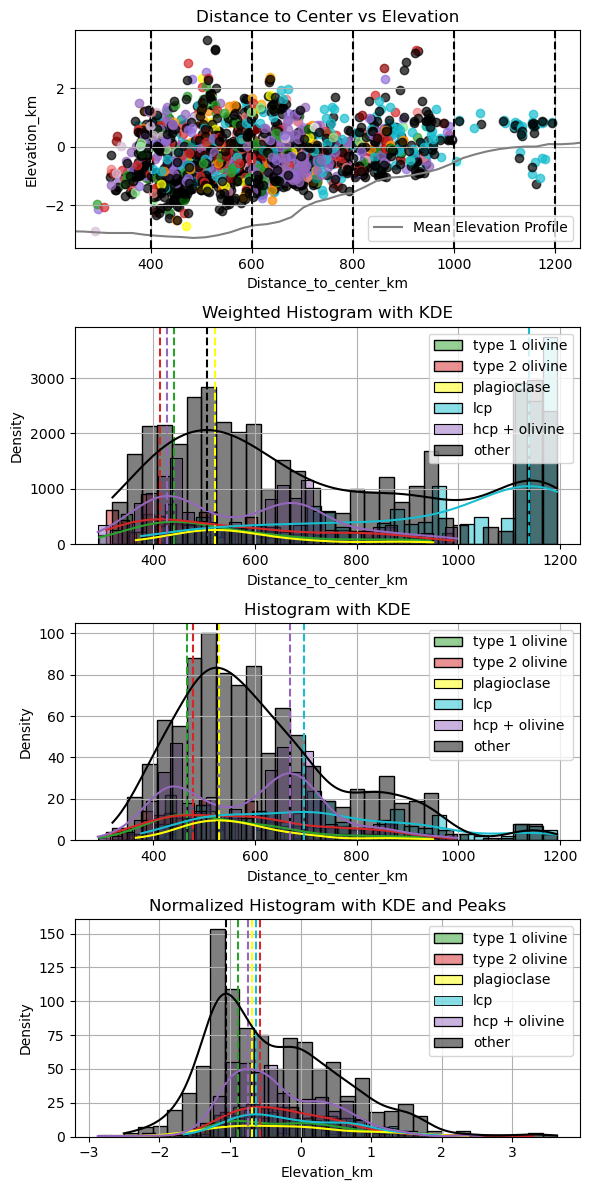

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.nonparametric.kernel_density import KDEMultivariate
from scipy.stats import gaussian_kde
import numpy as np
from scipy.interpolate import interp1d
from statsmodels.nonparametric.smoothers_lowess import lowess

# Load the categorized Excel file
file_path = '/Users/phillipsm/Documents/Research/MassifMapping/Argyre_QGIS/mineral_unit_metadata_categorized_12172024.xlsx'
df = pd.read_excel(file_path)

# Define a color map for categories and confidence levels
category_colors = {
    'type 1 olivine': {'High': 'tab:green', 'Moderate': 'darkgreen', 'Low': 'lightgreen'},
    'type 2 olivine': {'High': 'tab:red', 'Moderate': 'darkred', 'Low': 'lightcoral'},
    'olivine': {'High': 'tab:red', 'Moderate': 'darkred', 'Low': 'lightcoral'},
    'hcp + olivine': {'High': 'tab:purple', 'Moderate': 'mediumpurple', 'Low': 'thistle'},
    'lcp': {'High': 'tab:cyan', 'Moderate': 'darkcyan', 'Low': 'lightcyan'},
    'plagioclase': {'High': 'yellow', 'Moderate': 'orange', 'Low': 'darkorange'},
    'alteration + olivine': {'High': 'tab:purple', 'Moderate': 'darkslateblue', 'Low': 'thistle'},
    'olivine + plagioclase': {'High': 'tab:green', 'Moderate': 'darkgreen', 'Low': 'lightgreen'},
    'alteration + olivine + plagioclase': {'High': 'tab:cyan', 'Moderate': 'darkcyan', 'Low': 'lightcyan'},
    'alteration + plagioclase': {'High': 'tab:brown', 'Moderate': 'saddlebrown', 'Low': 'peru'},
    'hcp + lcp': {'High': 'tab:pink', 'Moderate': 'hotpink', 'Low': 'lightpink'},
    'alteration + hcp + olivine': {'High': 'tab:orange', 'Moderate': 'darkorange', 'Low': 'lightsalmon'},
    'hcp + olivine + plagioclase': {'High': 'lime', 'Moderate': 'green', 'Low': 'lightgreen'},
    'red slope': {'High': 'tab:gray', 'Moderate': 'darkgray', 'Low': 'lightgray'},
    'alteration': {'High': 'tab:blue', 'Moderate': 'mediumblue', 'Low': 'lightblue'},
    'lcp + olivine': {'High': 'tab:brown', 'Moderate': 'saddlebrown', 'Low': 'peru'},
    'hcp + plagioclase': {'High': 'tab:olive', 'Moderate': 'darkkhaki', 'Low': 'palegoldenrod'},
    'hcp + lcp + olivine': {'High': 'teal', 'Moderate': 'darkslategray', 'Low': 'lightseagreen'},
    'lcp + plagioclase': {'High': 'tab:olive', 'Moderate': 'darkkhaki', 'Low': 'palegoldenrod'},
    'lcp + olivine + plagioclase': {'High': 'gold', 'Moderate': 'darkgoldenrod', 'Low': 'khaki'},
    'hcp': {'High': 'tab:pink', 'Moderate': 'hotpink', 'Low': 'lightpink'},
    'olivine + olivine': {'High': 'tab:green', 'Moderate': 'darkgreen', 'Low': 'lightgreen'},
    'alteration + lcp': {'High': 'tab:olive', 'Moderate': 'darkolivegreen', 'Low': 'lightgreen'},
    'alteration + hcp + olivine + plagioclase': {'High': 'tab:purple', 'Moderate': 'mediumpurple', 'Low': 'thistle'},
    'plagioclase + red slope': {'High': 'tab:orange', 'Moderate': 'chocolate', 'Low': 'lightsalmon'},
    'hcp + lcp + olivine + plagioclase': {'High': 'maroon', 'Moderate': 'darkred', 'Low': 'lightcoral'},
    'other': {'High': 'black', 'Moderate': 'dimgray', 'Low': 'lightgray'},
    'denom': {'High': 'black', 'Moderate': 'dimgray', 'Low': 'lightgray'},
}

# Function to filter data based on confidence levels and categories
def filter_data(df, confidence_levels, categories_to_include):
    if not categories_to_include:
        categories_to_include = list(category_colors.keys())

    if not confidence_levels:
        return df[(df['Category'] != 'No valid mineral') & (df['Category'].isin(categories_to_include))]
    else:
        confidence_levels_lower = [a.lower() for a in confidence_levels]
        return df[(df['Category'] != 'No valid mineral') & 
                  (df['Confidence'].isin(confidence_levels_lower)) & 
                  (df['Category'].isin(categories_to_include))]

# Define which categories to include in the plot
categories_to_include = ['type 1 olivine', 'type 2 olivine', 'plagioclase', 'lcp', 'hcp + olivine', 'other']
# categories_to_include = list(category_colors.keys())  # Uncomment to include all categories

# Filter data based on confidence levels and categories to include
# confidence_levels_to_include = ['High']
# confidence_levels_to_include = ['High', 'Moderate']
confidence_levels_to_include = ['High', 'Moderate', 'Low']

units_to_include = ['Argyre basin member 2', 
                    'Argyre basin member 3', 
                    'Argyre rim materials', 
                    'Argyre rim and basin materials', 
                    'Argyre basin and rim materials',
                    'Young crater materials', 
                    'Old crater materials']

df_filtered = filter_data(df, confidence_levels_to_include, categories_to_include)
df_filtered = df_filtered[df_filtered['GeoUnits'].isin(units_to_include)]

mean_profile_df = pd.read_excel('/Users/phillipsm/Documents/Research/MassifMapping/Argyre_QGIS/averaged_topo.xlsx')
mean_profile_interp = interp1d(mean_profile_df['Distance'], mean_profile_df['Average Elevation']/1000)

# Filter the data to include only points where elevation is above the interpolated mean elevation at the corresponding distance
df_filtered_above_mean = df_filtered[df_filtered['Elevation_km'] > mean_profile_interp(df_filtered['Distance_to_center_km'])]

rings_ = [400, 600, 800, 1000, 1200]
# Plot Distance_to_center_km vs Elevation_km
plt.figure(figsize=(6, 12))

# Scatter plot with LOESS Smoothed Line
points_count = {}
for cat in categories_to_include:
    points_count[cat] = 0
plt.subplot(4, 1, 1)
for index, row in df_filtered.iterrows():
    category = row['Category']
    confidence = row['Confidence'].capitalize()
    if category in category_colors:
        color = category_colors[category][confidence]
        plt.scatter(row['Distance_to_center_km'], row['Elevation_km'], color=color, alpha=0.7)
        points_count[category] += 1

plt.plot(mean_profile_df['Distance'], mean_profile_df['Average Elevation']/1000, color='gray', label='Mean Elevation Profile')
for ring in rings_:
    plt.axvline(ring, linestyle='--', color='k', linewidth=1.5)
plt.xlim(250,1250)
# plt.yscale('log')
plt.xlabel('Distance_to_center_km')
plt.ylabel('Elevation_km')
plt.title('Distance to Center vs Elevation')
plt.grid(True)

# Smooth the data using LOESS
loess_smoothed = lowess(df_filtered['Elevation_km'], df_filtered['Distance_to_center_km'], frac=0.1)
# plt.plot(loess_smoothed[:, 0], loess_smoothed[:, 1], color='black', label='LOESS Smoothed')
plt.legend()

# Normalized Histogram plot with KDE
plt.subplot(4, 1, 2)
for category in categories_to_include:
    # if category == 'hcp':
    #     continue
    # data = df_filtered_above_mean[df_filtered_above_mean['Category'] == category]['Distance_to_center_km']
    data = df_filtered[df_filtered['Category'] == category]['Distance_to_center_km']
    
    weights = []
    for d in data:
        try:
            ridx = np.where(d * 1000 <= area_sum_by_ring['distance'].values)[0][0]
        except IndexError:
            ridx = -1
        w = 1 / area_sum_by_ring['normalized_area'].values[ridx]
        weights.append(w)
    
    sns.histplot(x=data, weights=weights, kde=True, bins=30, color=category_colors[category]['High'],
                label=f'{category}')
    
    # Calculate the KDE using scipy to find the peak
    kde = gaussian_kde(data, weights=weights)
    x_vals = np.linspace(data.min(), data.max(), 1000)
    kde_vals = kde(x_vals)
    
    # Find the x-coordinate of the peak
    kde_peak = x_vals[np.argmax(kde_vals)]
    
    # Add a vertical dashed line at the KDE peak
    plt.axvline(kde_peak, linestyle='--', color=category_colors[category]['High'], linewidth=1.5)

# for ring in rings_:
#     plt.axvline(ring, linestyle='--', color='k', linewidth=1.5)

plt.xlabel('Distance_to_center_km')
plt.ylabel('Density')
plt.title('Weighted Histogram with KDE')
plt.legend()
plt.grid(True)

# Normalized Histogram plot with KDE
plt.subplot(4, 1, 3)
for category in categories_to_include:
    # if category == 'hcp':
    #     continue
    # data = df_filtered_above_mean[df_filtered_above_mean['Category'] == category]['Distance_to_center_km']
    data = df_filtered[df_filtered['Category'] == category]['Distance_to_center_km']
    
    sns.histplot(data, kde=True, bins=30, color=category_colors[category]['High'],
                label=f'{category}')
    
    # Calculate the KDE using scipy to find the peak
    kde = gaussian_kde(data)
    x_vals = np.linspace(data.min(), data.max(), 1000)
    kde_vals = kde(x_vals)
    
    # Find the x-coordinate of the peak
    kde_peak = x_vals[np.argmax(kde_vals)]
    
    # Add a vertical dashed line at the KDE peak
    plt.axvline(kde_peak, linestyle='--', color=category_colors[category]['High'], linewidth=1.5)

# for ring in rings_:
#     plt.axvline(ring, linestyle='--', color='k', linewidth=1.5)

plt.xlabel('Distance_to_center_km')
plt.ylabel('Density')
plt.title('Histogram with KDE')
plt.legend()
plt.grid(True)

# Normalized Histogram plot with KDE
plt.subplot(4, 1, 4)

for category in categories_to_include:
    # Get the data for the current category
    data = df_filtered[df_filtered['Category'] == category]['Elevation_km']
    
    # Plot the histogram with KDE
    sns.histplot(data, kde=True, bins=30, color=category_colors[category]['High'], label=category)
    
    # Calculate the KDE using scipy to find the peak
    kde = gaussian_kde(data)
    x_vals = np.linspace(data.min(), data.max(), 1000)
    kde_vals = kde(x_vals)
    
    # Find the x-coordinate of the peak
    kde_peak = x_vals[np.argmax(kde_vals)]
    
    # Add a vertical dashed line at the KDE peak
    plt.axvline(kde_peak, linestyle='--', color=category_colors[category]['High'], linewidth=1.5)

# Labels and legend
plt.xlabel('Elevation_km')
plt.ylabel('Density')
plt.title('Normalized Histogram with KDE and Peaks')
plt.legend()
plt.grid(True)

plt.tight_layout()


In [5]:
df_filtered.groupby('Category').sum()
category_counts = df_filtered['Category'].value_counts()
category_counts

other             1333
hcp + olivine      490
lcp                373
type 2 olivine     310
type 1 olivine     234
plagioclase        134
Name: Category, dtype: int64

In [6]:
# hcp + olivine      446
# lcp                266
# type 2 olivine     231
# type 1 olivine     179
# plagioclase        123
446+266+231+179+123

1245

In [13]:
df_filtered.groupby('Category').std()

,Polygon_ID,Polygon Number,Elevation_km,Distance_to_center_km
Category,,,,
hcp + olivine,97.955058,97.955058,0.686214,140.798751
lcp,100.324753,100.324753,0.779498,196.277874
plagioclase,112.136543,112.136543,0.998102,110.210350
type 1 olivine,39.863535,39.863535,0.779183,160.358469
type 2 olivine,96.316511,96.316511,0.899733,165.694990


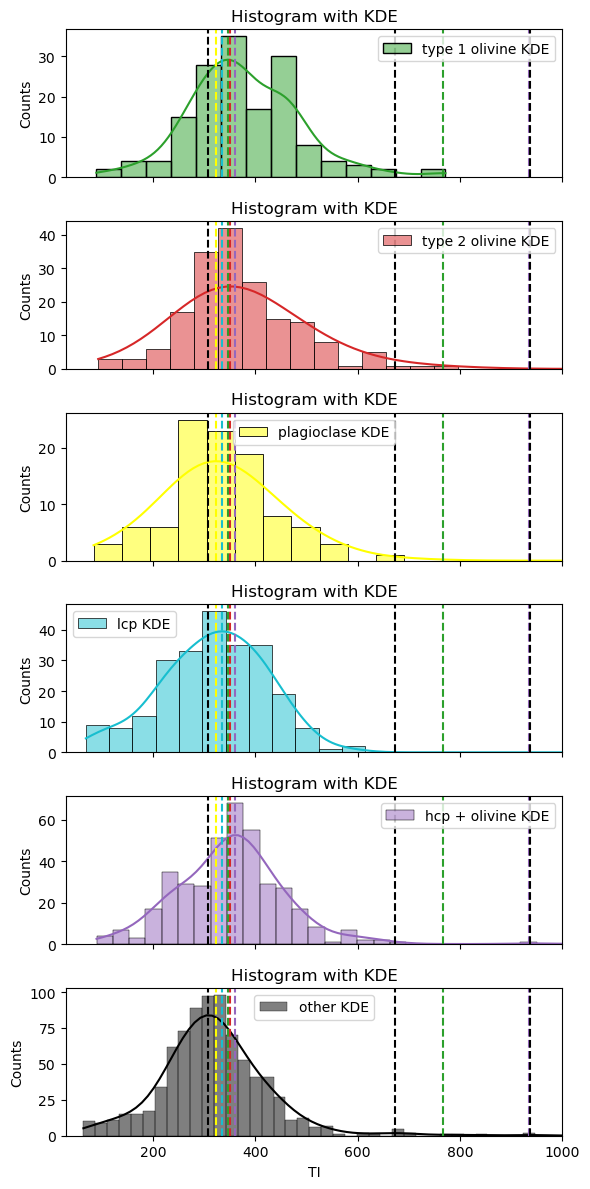

In [30]:

fig, axs = plt.subplots(len(categories_to_include), 1, figsize=(6, 12), sharex=True)
kde_peaks = []
ax_list = []

# Loop over each category
for i, category in enumerate(categories_to_include):
    data = df_filtered[df_filtered['Category'] == category]['TI']

    data = data.dropna()
    
    # # Define bins to align with the ring distances
    # max_distance = data.max()
    # ring_edges = list(np.array(buffer_distances) / 1000)  # Divide buffer_distances by 1000 to convert to km
    # bin_edges = [edge for edge in ring_edges if edge <= max_distance]
    
    # weights = []
    # for d in data:
    #     try:
    #         ridx = np.where(d * 1000 <= area_sum_by_ring['distance'].values)[0][0]
    #     except IndexError:
    #         ridx = -1
    #     w = 1 / area_sum_by_ring['normalized_area'].values[ridx]
    #     weights.append(w)

    # tw = max(weights)
    # weights = [w/tw for w in weights]

    # Plot KDE with weights
    sns.histplot(x=data, kde=True, color=category_colors[category]['High'],
                 label=f'{category} KDE', ax=axs[i])
    
    # Calculate and plot KDE peak
    kde = gaussian_kde(data)
    x_vals = np.linspace(data.min(), data.max(), 1000)
    kde_vals = kde(x_vals)
    # Find the peaks in the KDE values
    peaks, _ = find_peaks(kde_vals)
    kde_peak = x_vals[peaks]
    # kde_peak = x_vals[np.argmax(kde_vals)]
    kde_peaks.append(kde_peak)
    
    # Set plot title and vertical line at KDE peak
    axs[i].set_title('Histogram with KDE')
    axs[i].legend()
    axs[i].set_ylabel('Counts')
    ax_list.append(axs[i])

for ax in ax_list:
    for i, kde_peak in enumerate(kde_peaks):
        if len(kde_peak) > 1:
            for kp in kde_peak:
                # Add a vertical dashed line at the KDE peak
                ax.axvline(kp, linestyle='--', color=category_colors[categories_to_include[i]]['High'], linewidth=1.5)
        else:
            # Add a vertical dashed line at the KDE peak
            ax.axvline(kde_peak, linestyle='--', color=category_colors[categories_to_include[i]]['High'], linewidth=1.5)

plt.xlabel('TI')
plt.xlim(30, 1000)
plt.tight_layout()
plt.show()

In [24]:
# Calculate each statistic separately
mean_area = df_filtered.groupby('Category')['TI'].mean().rename('mean_TI').reset_index()
std_area = df_filtered.groupby('Category')['TI'].std().rename('std_TI').reset_index()
min_area = df_filtered.groupby('Category')['TI'].min().rename('min_TI').reset_index()
max_area = df_filtered.groupby('Category')['TI'].max().rename('max_TI').reset_index()

# Merge all the statistics into a single DataFrame
stats_area_by_category = mean_area.merge(std_area, on='Category') \
                        .merge(min_area, on='Category') \
                        .merge(max_area, on='Category')
stats_area_by_category #.to_excel('stats_area_by_category.xlsx', index=False)


,Category,mean_TI,std_TI,min_TI,max_TI
0,hcp + olivine,357.110327,135.670510,89.886581,2128.238037
1,lcp,323.051198,119.169756,69.041771,1297.257324
2,plagioclase,349.233521,206.411092,83.967178,2127.735352
3,type 1 olivine,379.440692,110.277294,89.474922,771.834961
4,type 2 olivine,402.943130,267.417799,93.066658,2856.924072


In [25]:

# Calculate each statistic separately
median_area = df_filtered.groupby('Category')['TI'].median().rename('median_TI').reset_index()
min_area = df_filtered.groupby('Category')['TI'].min().rename('min_TI').reset_index()
max_area = df_filtered.groupby('Category')['TI'].max().rename('max_TI').reset_index()
quantile_area = df_filtered.groupby('Category')['TI'].quantile(0.25).rename('quantile_25_TI').reset_index()

# Merge all the statistics into a single DataFrame
stats_area_by_category = median_area.merge(min_area, on='Category') \
                        .merge(max_area, on='Category') \
                        .merge(quantile_area, on='Category')
stats_area_by_category #.to_excel('stats_area_by_category.xlsx', index=False)


,Category,median_TI,min_TI,max_TI,quantile_25_TI
0,hcp + olivine,353.655914,89.886581,2128.238037,289.198303
1,lcp,325.936157,69.041771,1297.257324,252.007095
2,plagioclase,318.527039,83.967178,2127.735352,266.172821
3,type 1 olivine,367.390305,89.474922,771.834961,308.104195
4,type 2 olivine,358.106171,93.066658,2856.924072,304.279297


In [11]:
# get the polygon number of the maximum plagioclase TI
top_10_plag = df_filtered[df_filtered['Category'] == 'plagioclase'].nlargest(10, 'TI')
top_10_plag_info = top_10_plag[['Source File', 'Polygon Number', 'TI', 'Elevation_km', 'Distance_to_center_km', 'GeoUnits']]
top_10_plag_info

,Source File,Polygon Number,TI,Elevation_km,Distance_to_center_km,GeoUnits
1330,T0432,34,2127.735352,2.351143,501.22,Argyre rim materials
2438,T0363,50,558.934204,-1.389565,512.51,Argyre basin member 3
1383,T0432,87,553.895142,0.250061,582.09,Argyre basin and rim materials
264,T0435,163,526.067688,-0.878700,492.79,Argyre basin and rim materials
466,T0435,365,478.484711,1.455519,618.65,Argyre basin and rim materials
242,T0435,141,472.428864,-0.768423,453.27,Argyre basin and rim materials
2222,T0505,82,461.348206,1.749038,636.63,Old crater materials
2140,T0505,0,442.631744,0.003126,567.79,Smooth crater floor materials
226,T0435,125,425.487793,-0.402571,472.29,Argyre basin and rim materials
2048,T0236,33,419.828094,-0.703581,669.71,Argyre basin and rim materials
